### Exemplar Retrieval Model(ERM) - Sieve 2001 (8 May, 2016 by Huiji)
* Step1: **Encode cues**: profile of the stimulus examined
* Step2: **Exemplar retrieval**: 
    - $$ similarity(j, k) = \prod s^{d_k}$$
        - $k$ from 1 to $j-1$;
        - similarity: a multiplicative combination along various dimensions; 
        - $d_k$ the number of mismatching features between $j$ and $k$;
        - $s$ the similarity of mismatching values for each feature (measuring the degree to which respondants fail to notice mismatching values: if $s=1$, the mismatch is not noticed and the similarity is not influenced by that dimension; if $s=0$, the mismatch in this dimension overrules all other dimensions and nullifies the similarity regardless of how many other matching features there are)).
    - The probability of a previous instance $k$ is retrived given the new stimulus $j$ is observed
$$p(retrieve\_exemplar\_K\ |\ new\_stimulus\_J) = \frac{similarity(j,k)}{\sum_k{similarity(j,k)}}$$

    - The total probability of any previous TYPICAL instances are retrived given the new stimulus $j$ is observed
$$p(k \in T\ |\ new\_stimulus\_J) = \frac{\sum_{k\in T}{similarity(j,k)}}{\sum_{k\in T}{similarity(j,k)}+\sum_{k\notin T}{similarity(j,k)}}$$
    
* Step3: **Balance assessment**:
    - $$ S_N = \sum^N_{i=1}{X_i}$$
        - $X_i$: each of the outcomes in the sample of retrieved cases (eg: $X_i = 1$ if the $i$th exemplar is TYPICAL, and $X_i = -1$ if otherwise);
        - $N$: constant representing the number of past cases that were retrieved on each trial at the time of the choice response
* Step4: **Choice**: The respondent chooses the category that is favored in Step3.
* Step5: **Probability Judgement**:
    - $$F_{T,N} = \frac{\eta + N +S_N}{\eta+\theta +2N}$$
        - $\frac{\eta}{\eta+\theta}$: personal probability distribution prior to any retrieval

### Exemplar Model (Nilsson 2008) (8 May, 2016 by Huiji)

* The probability that object $t$ belongs to Category $A$:
    - $$p(A) = \frac{\sum_{t}{similarity(t\ |\ x_i)}*c(x_i)}{\sum_t{similarity(t\ |\ x_i)}}$$
        - $x_i$: exemplars from memory $i = 1, 2, ..., I$
        - $c(x_i) = 1$ if $x_1$ belong to $A$; $c(x_i)= 0$ otherwise.
        

### Simulation data from Nilsson 2008 (9 May, by Huiji)

In [1]:
file = open("data/Sim_Nilsson_2008.txt")
title = file.readline()
col_title = file.readline().strip().split(" ")
exemplar_list = []
for line in file:
    line = line.strip()
    if (line):
        exemplar = line.split(" ")
        exemplar_list.append(exemplar)
print(title)
print(col_title)
for exemplar in exemplar_list:
    print(exemplar)

Category structure with the 12 unique exemplars and their presentation frequency in each category

['E', 'C1', 'C2', 'C3', 'C4', 'FreqA', 'FreqB']
['E1', '0', '0', '0', '0', '0', '14']
['E2', '0', '0', '0', '1', '0', '6']
['E3', '0', '0', '1', '0', '0', '1']
['E4', '0', '1', '0', '0', '0', '1']
['E5', '1', '0', '0', '0', '5', '1']
['E6', '0', '1', '1', '0', '1', '1']
['E7', '1', '0', '0', '1', '1', '1']
['E8', '0', '1', '1', '1', '6', '0']
['E9', '1', '0', '1', '1', '1', '0']
['E10', '1', '1', '0', '1', '1', '0']
['E11', '1', '1', '1', '0', '1', '5']
['E12', '1', '1', '1', '1', '14', '0']


**Notes:** The two most important feature combinations are E5 and E11 (further on referred to as critical exemplars). The critical exemplars share a low number of features with the members of the category they belong more often to (0.96 features on average) and a high number of features with the category they belong less often to (2.53 features on average). Remember, a representativeness effect occurs when an object is judged as belonging to a category to which it seldom belongs only because it shares a high number of features with the members of that category. Accordingly, representativeness effects are hypothesized to occur in the probability judgments of the critical exemplars.

## ERM

In [2]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import copy

### Read features and population distributions

In [3]:
# Step -1: Read files - originally written for exemplars in Nisson (2005) by Huiji, 9 May
#                     - later updated together for the Linda data, 12 May

def read_features(filename):
    file = open(filename)
    features = []
    for line in file:
        features.append(line.strip())
    return features

def read_distribution(filename):
    file = open(filename)
    categories = file.readline().strip().split(",")
    distribution = []
    for line in file:
        prob = line.strip().split(",")
        for i in range(len(prob)):
            prob[i] = float(prob[i])
        prob = np.array(prob)
        distribution.append(prob)
    distribution = np.array(distribution)    
    return categories, distribution

In [4]:
features = read_features("data/linda_adjectives.txt")
categories, distribution = read_distribution("data/linda_distribution.txt")
print(features)
print(categories)
print(distribution)

['Around 30 years old', 'Single', 'Outspoken', 'Intelligent', 'Humanities major', 'Concerned with discrimination and social justice', 'Participated in demonstrations', 'Female']
['B', 'F', 'NotB_NotF', 'BF']
[[ 0.7  0.4  0.3  0.7]
 [ 0.4  0.8  0.5  0.8]
 [ 0.3  0.8  0.4  0.8]
 [ 0.5  0.7  0.5  0.7]
 [ 0.2  0.8  0.5  0.8]
 [ 0.4  0.9  0.4  0.9]
 [ 0.2  0.8  0.2  0.8]
 [ 0.8  0.9  0.5  0.9]]


### Generate Simulated Exemplars

In [5]:
# Step 1: Generate exemplars - written together, 12 May

def generate_exemplars(features, distribution, category_index, numExemplars):
    distr_category = distribution[:,category_index]
    exemplars = []
    for i in range(numExemplars):
        exemplar = np.zeros(len(features))        
        for j in range(len(distr_category)):
            random.seed(datetime.now())
            n = random.random()
            if (n >= (1-distr_category[j])):
                exemplar[j] = 1
        exemplars.append(exemplar)
    exemplars = np.array(exemplars)
    return exemplars

In [6]:
bank_teller_exemplars = generate_exemplars(features, distribution, 0, 10)
feminist_exemplars = generate_exemplars(features, distribution, 1, 10)
not_bank_not_feminist_exemplars = generate_exemplars(features, distribution, 2, 30)
feminist_banker_exemplars = generate_exemplars(features, distribution, 3, 3)
print("B:",bank_teller_exemplars[:3])
print("F:",feminist_exemplars[:3])
print("NBNF:",not_bank_not_feminist_exemplars[:5])
print("FB:",feminist_banker_exemplars[:1])

B: [[ 1.  1.  0.  0.  0.  1.  1.  1.]
 [ 1.  1.  1.  0.  0.  0.  1.  1.]
 [ 1.  1.  1.  0.  0.  1.  0.  1.]]
F: [[ 1.  0.  1.  0.  1.  1.  1.  1.]
 [ 0.  1.  0.  1.  1.  1.  1.  1.]
 [ 0.  1.  1.  1.  1.  1.  1.  1.]]
NBNF: [[ 0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  0.  1.]]
FB: [[ 1.  1.  0.  1.  1.  1.  0.  1.]]


In [7]:
exemplars_direct_test = np.concatenate((bank_teller_exemplars, feminist_exemplars, feminist_banker_exemplars))
print(exemplars_direct_test[:10])

[[ 1.  1.  0.  0.  0.  1.  1.  1.]
 [ 1.  1.  1.  0.  0.  0.  1.  1.]
 [ 1.  1.  1.  0.  0.  1.  0.  1.]
 [ 1.  1.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  1.  0.  1.  1.  0.]
 [ 1.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  1.  0.  0.  1.  0.  0.  1.]
 [ 0.  1.  0.  1.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  1.  1.]
 [ 1.  0.  0.  0.  0.  1.  0.  1.]]


### Similarity Function

In [8]:
# step 2: exemplar retrieval - by Huiji, 9 May
def similarity(j,k,feat_weights):
    simil = 1
    for i in range(len(j)):
        # let s for every dimension be 0.5 so every dim is equal for now
        # for now, each dimension only has one feature which is binary
        s = feat_weights[i]
        if j[i] == k[i]:
            s = 0
        simil = simil * (1-s)
    return simil

$$ similarity(j, k) = \prod s^{d_k}$$

### Feature Weights

In [9]:
feat_weights = [0.5,0.5,0.75,0.5]
print(similarity(['0','0','0','0'],['0','0','0','1'],feat_weights))
print(similarity(['0','0','0','0'],['0','0','1','1'],feat_weights))

0.5
0.125


### Exemplar Retrieval

In [10]:
def prob_retrieve_k(exemplar_list, j, k, feat_weights):
    # probability of retrieve a single instance - originally writtern by Huiji, 9 May
    # - updated together later for Linda data, 12 May
    
    inMem = 0
    for exemplar in exemplar_list:
        if np.array_equal(k, exemplar):
            inMem = 1
            break
    if inMem == 0:
        return 0
    total = 0
    sim_jk = similarity(j,k,feat_weights)
    for i in exemplar_list:
        sim_ji = similarity(j,i,feat_weights)
        total += sim_ji
    prob = sim_jk/total
    
    return prob

$$p(retrieve\_exemplar\_K\ |\ new\_stimulus\_J) = \frac{similarity(j,k)}{\sum_k{similarity(j,k)}}$$

In [11]:
# treat all features as equally important
feat_weights = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

# test with a known banker
banker = exemplars_direct_test[0]
print(prob_retrieve_k(bank_teller_exemplars, banker, banker, feat_weights))
print(prob_retrieve_k(feminist_exemplars, banker, banker, feat_weights))
print(prob_retrieve_k(exemplars_direct_test, banker, banker, feat_weights))


total = 0
for exemplar in exemplars_direct_test:
    total += prob_retrieve_k(exemplars_direct_test, banker, exemplar, feat_weights)
print(total)

0.4
0
0.2788671023965142
1.0000000000000002


In [12]:
# Find the probability of a retrieved exemplar is from a certain category - originally written by Huiji, 9 May
# - updated together later for Linda data, 12 May

def prob_retrieve_category(category, all_exemplars, j, feat_weights):
    total_sim = 0
    target_cate_sim = 0
    for k in category: 
        target_cate_sim += similarity(j,k,feat_weights)
    for exemplar in all_exemplars:
        total_sim += similarity(j,exemplar,feat_weights)
    return target_cate_sim/total_sim


In [13]:
# test with a known banker (direct test - comparing all the statements to each other) - written together, 12 May
prob_cate_list = []
prob_cate_list.append(prob_retrieve_category(bank_teller_exemplars, exemplars_direct_test, banker, feat_weights))
prob_cate_list.append(prob_retrieve_category(feminist_exemplars, exemplars_direct_test, banker, feat_weights))
prob_cate_list.append(prob_retrieve_category(feminist_banker_exemplars, exemplars_direct_test, banker, feat_weights))
print(prob_cate_list)
total = 0
for i in prob_cate_list:
    total += i
print(total)

[0.6971677559912854, 0.19389978213507625, 0.10893246187363835]
1.0


### Linda Direct Test: 1 iteration (BF size: 30% of B and of F)

In [14]:
# LINDA!!!! (direct test - comparing all the statements to each other) - written together, 12 May
linda = np.array([1,1,1,1,1,1,1,1])
linda_cate_list = []
linda_cate_list.append(prob_retrieve_category(bank_teller_exemplars, exemplars_direct_test, linda, feat_weights))
linda_cate_list.append(prob_retrieve_category(feminist_exemplars, exemplars_direct_test, linda, feat_weights))
linda_cate_list.append(prob_retrieve_category(feminist_banker_exemplars, exemplars_direct_test, linda, feat_weights))
print("Bank Teller: ", linda_cate_list[0])
print("Feminist: ", linda_cate_list[1])
print("Feminist Bank Teller: ", linda_cate_list[2])

Bank Teller:  0.18448637316561844
Feminist:  0.6121593291404612
Feminist Bank Teller:  0.20335429769392033


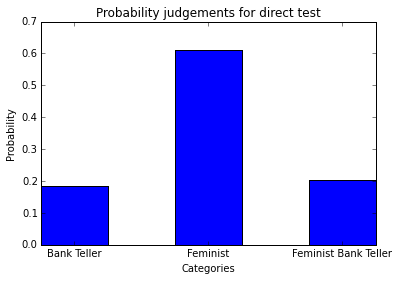

In [55]:
# Assuming people base their probability judgements
# (in this case, ranking statements) directly based
# on the number of exemplars they retrieved

# Bar graph to display the rankings - 26 May, by Huiji
plt.bar(np.arange(0,3,1), linda_cate_list, 0.5)
plt.title("Probability judgements for direct test")
plt.xlabel("Categories")
plt.ylabel("Probability")
plt.xticks(np.arange(0,3,1)+0.5/2, ["Bank Teller", "Feminist","Feminist Bank Teller"])
plt.show()

### Linda Indirect Test: 1 iteration (BF size: 30% of B and of F, Common ppl: 3*B)

In [16]:
# LINDA!!!! (indirect test - comparing each statement with common people) - 26 May, by Huiji
linda_cate_list_ind = []

bank_indirect_test = np.concatenate((bank_teller_exemplars, not_bank_not_feminist_exemplars))
feminist_indirect_test = np.concatenate((feminist_exemplars, not_bank_not_feminist_exemplars))
conj_indirect_test = np.concatenate((feminist_banker_exemplars, not_bank_not_feminist_exemplars))

linda_cate_list_ind.append(prob_retrieve_category(bank_teller_exemplars, bank_indirect_test, linda, feat_weights))
linda_cate_list_ind.append(prob_retrieve_category(feminist_exemplars, feminist_indirect_test, linda, feat_weights))
linda_cate_list_ind.append(prob_retrieve_category(feminist_banker_exemplars, conj_indirect_test, linda, feat_weights))
print("Bank Teller: ", linda_cate_list_ind[0])
print("Feminist: ", linda_cate_list_ind[1])
print("Feminist Bank Teller: ", linda_cate_list_ind[2])

Bank Teller:  0.2410958904109589
Feminist:  0.5131810193321616
Feminist Bank Teller:  0.25935828877005346


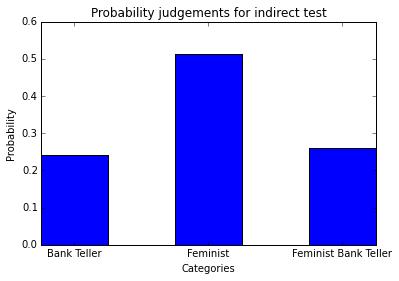

In [17]:
# Assuming people base their probability judgements
# (in this case, ranking statements) directly based
# on the number of exemplars they retrieved

# Bar graph to display the rankings - 26 May, by Huiji
plt.bar(np.arange(0,3,1), linda_cate_list_ind, 0.5)
plt.title("Probability judgements for indirect test")
plt.xlabel("Categories")
plt.ylabel("Probability")
plt.xticks(np.arange(0,3,1)+0.5/2, ["Bank Teller", "Feminist","Feminist Bank Teller"])
plt.show()

## Linda's Direct Test: 100 iterations

### Small memory size  (BF size: 30% of B and of F)

In [18]:
def directTest(test_stimulus, feat_weights, iterations, features, distribution, num_e_stored):
    dirTest_matrix = []
    for i in range(iterations):
        # generate new set of exemplars for each participant
        dirB_exemplars = generate_exemplars(features, distribution, 0, num_e_stored[0])
        dirF_exemplars = generate_exemplars(features, distribution, 1, num_e_stored[1])
        dirBF_exemplars = generate_exemplars(features, distribution, 3, num_e_stored[2])
        # concatenate to get the set of all exemplars a participant has
        dirAll_exemplars= np.concatenate((dirB_exemplars, dirF_exemplars, dirBF_exemplars))

        dir_cate_list = []
        dir_cate_list.append(prob_retrieve_category(dirB_exemplars, dirAll_exemplars, test_stimulus, feat_weights))
        dir_cate_list.append(prob_retrieve_category(dirF_exemplars, dirAll_exemplars, test_stimulus, feat_weights))
        dir_cate_list.append(prob_retrieve_category(dirBF_exemplars, dirAll_exemplars, test_stimulus, feat_weights))
        dirTest_matrix.append(dir_cate_list)

    dirTest_matrix = np.array(dirTest_matrix)
    return dirTest_matrix

def getStdMean(matrix):
    # get mean and standard deviation for probability ratings
    Std = []
    Mean = []
    for i in range(3):
        a = matrix[:,i]
        std = np.std(a)
        mean = np.mean(a)
        Std.append(std)
        Mean.append(mean)
    return Std, Mean

In [19]:
iterations = 100
linda = np.array([1,1,1,1,1,1,1,1])
feat_weights = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
dirTest_matrix = directTest(linda,feat_weights, iterations, features, distribution, [10,10,3])
dirStd, dirMean = getStdMean(dirTest_matrix)
print (dirStd, dirMean)

[0.044272946593590261, 0.079088282838810933, 0.074436935063819182] [0.12021253582134006, 0.64880566884215485, 0.23098179533650512]


### Large Memory Size  (BF size: 30% of B and of F)

In [20]:
# Run direct tests with multiple iterations to mimic multiple participants in the human experiments
# with equally big memory size for participants (B:100, F:100, BF: 30)
# - 26 May, by Huiji

dirTest_matrix_b = directTest(linda,feat_weights, iterations, features, distribution, [100,100,30])
dirStd_b, dirMean_b = getStdMean(dirTest_matrix_b)
print (dirStd_b, dirMean_b)

[0.012579845600979909, 0.027749988245553768, 0.025638005667131172] [0.12284814534086301, 0.64327619576171402, 0.23387565889742309]


### Comparison

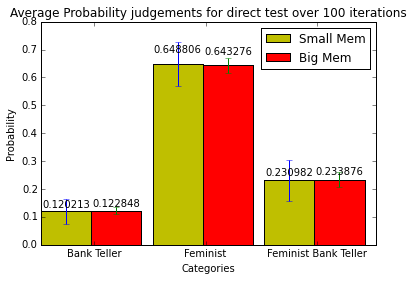

In [21]:
# Bar graph to display the rankings (mean and std) over 100 simulated participants
# with both small exemplar size (B:10, F:10, BF: 3) and big exemplar size (B:100 F:100 BF:30)
# - 26 May, by Huiji

fig, ax = plt.subplots()

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%f' % height,
                ha='center', va='bottom')
        
p1 = ax.bar(np.arange(0,3,1), dirMean, 0.45, color = 'y', yerr = dirStd)
p2 = ax.bar(np.arange(0,3,1)+0.45, dirMean_b, 0.45, color = 'r', yerr = dirStd_b)
plt.title("Average Probability judgements for direct test over 100 iterations")
plt.xlabel("Categories")
plt.ylabel("Probability")
plt.xticks(np.arange(0,3,1)+0.95/2, ["Bank Teller", "Feminist","Feminist Bank Teller"])
plt.legend((p1[0],p2[0]), ["Small Mem", "Big Mem"])

autolabel(p1)
autolabel(p2)

plt.show()

*NOTE: Average probability judgements are pretty consistent relative to the absolute exemplar set size. But with larger exemplar sets, we get smaller variance. *

### Linda Direct Test: Manipulate category size relationship

#### Keep B and F the same, Vary BF

In [22]:
# Run direct tests with multiple iterations to mimic multiple participants in the human experiments
# with varying BF size for participants (B:40, F:40, BF: x, x from 2 to 30, incrementing by 2)
# - 26 May, by Huiji

# Store mean and std for 8 different conditions
varyBF = []

for x in np.arange(2,32,2):
    varyBF_matrix = directTest(linda,feat_weights, iterations, features, distribution, [40,40,x])
    varyBF_dirStd, varyBF_dirMean = getStdMean(varyBF_matrix)
    X = [varyBF_dirStd, varyBF_dirMean]
    varyBF.append(X)

varyBF = np.array(varyBF)

In [23]:
def plot_multiple(meanStdMatrix, title, xlabel, xticklabels):
    cat1_std = meanStdMatrix[:,0][:,0]
    cat1_mean = meanStdMatrix[:,1][:,0]
    # std & mean for Feminist
    cat2_std = meanStdMatrix[:,0][:,1]
    cat2_mean = meanStdMatrix[:,1][:,1]
    # std & mean for Feminist Banker
    cat3_std = meanStdMatrix[:,0][:,2]
    cat3_mean = meanStdMatrix[:,1][:,2]

    width = 0.3
    fig = plt.figure(figsize=(12,4))
    ax = plt.subplot(111)
    ind = np.arange(len(cat1_mean))
    p1 = ax.bar(ind-width, cat1_mean, width, color= 'r', align = 'center', yerr = cat1_std)
    p2 = ax.bar(ind, cat2_mean, width, color= 'b',align = 'center', yerr = cat2_std)
    p3 = ax.bar(ind+width, cat3_mean, width, color= 'g',align = 'center', yerr = cat3_std)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Probability")
    ax.set_xticks(ind)
    ax.set_xticklabels(xticklabels)
    ax.autoscale(tight=True)
    plt.legend((p1[0],p2[0],p3[0]), ["Bank Teller", "Feminist","Feminist Banker"]
          ,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

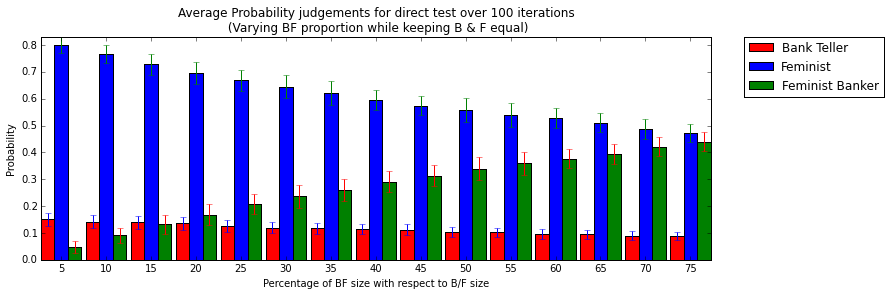

In [24]:
plot_multiple(varyBF,"Average Probability judgements for direct test over 100 iterations\n (Varying BF proportion while keeping B & F equal)",
             "Percentage of BF size with respect to B/F size", np.arange(2,32,2)*100//40)

As long as there are more than 15% of the bankers and feminists that are feminist banker, we see the conjunction fallacy. (In this test case, that is more than 6 people out of 40 bank tellers are active in feminist movements.)

#### Keep B and BF the same, Vary F

In [25]:
# Suppose that 30% of the bank tellers are active in feminist movements
# like we hypothesized in the basic version
# Run direct tests with multiple iterations to mimic multiple participants in the human experiments
# with varying BF size for participants (B:40, F:x, BF: 12, x from 24 to 60, incrementing by 4)
# - 26 May, by Huiji

# Store mean and std for 12 different conditions
varyF = []

for x in np.arange(12,62,4):
    varyF_matrix = directTest(linda,feat_weights, iterations, features, distribution, [40,x,12])
    varyF_dirStd, varyF_dirMean = getStdMean(varyF_matrix)
    X = [varyF_dirStd, varyF_dirMean]
    varyF.append(X)

varyF = np.array(varyF)

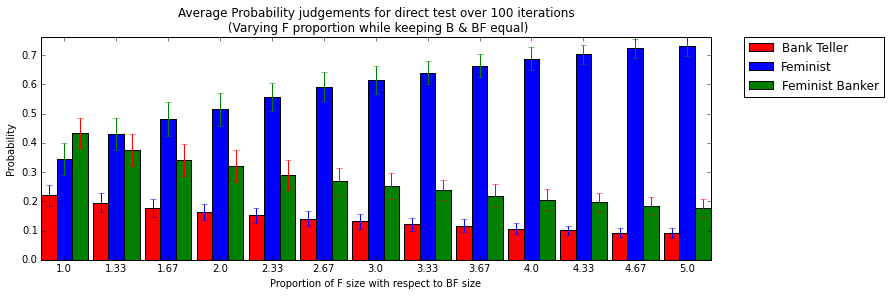

In [26]:
xticks = []
for i in np.arange(12,62,4):
    xticks.append(round(i/12, 2))
plot_multiple(varyF,"Average Probability judgements for direct test over 100 iterations\n (Varying F proportion while keeping B & BF equal)",
             "Proportion of F size with respect to BF size", xticks)

#### Keep F and BF the same, Vary B

In [27]:
# Suppose that 30% of the feminists are bank teller
# like we hypothesized in the basic version
# Run direct tests with multiple iterations to mimic multiple participants in the human experiments
# with varying BF size for participants (B:x, F:40, BF: 12, x from 24 to 60, incrementing by 4)
# - 26 May, by Huiji

# Store mean and std for 12 different conditions
varyB = []

for x in np.arange(40,104,4):
    varyB_matrix = directTest(linda,feat_weights, iterations, features, distribution, [x,40,12])
    varyB_dirStd, varyB_dirMean = getStdMean(varyB_matrix)
    X = [varyB_dirStd, varyB_dirMean]
    varyB.append(X)

varyB = np.array(varyB)

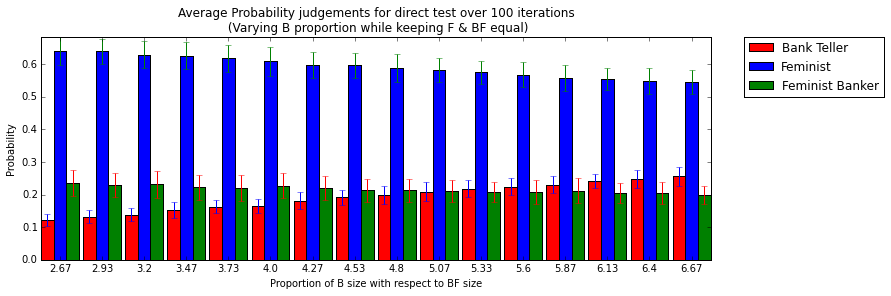

In [28]:
xticks = []
for i in np.arange(40,104,4):
    xticks.append(round(i/15, 2))
plot_multiple(varyB,"Average Probability judgements for direct test over 100 iterations\n (Varying B proportion while keeping F & BF equal)",
             "Proportion of B size with respect to BF size", xticks)# Plot the probability ratings of each category with respect to the change in B's proportion

## Linda Indirect Test: 100 iterations

In [29]:
def indirectTest(test_stimulus, feat_weights, iterations, features, distribution, num_e_stored):
    indirTest_matrix = []
    for i in range(iterations):
        # generate new set of exemplars for each participant
        indirB_exemplars = generate_exemplars(features, distribution, 0, num_e_stored[0])
        indirF_exemplars = generate_exemplars(features, distribution, 1, num_e_stored[1])
        indirBF_exemplars = generate_exemplars(features, distribution, 3, num_e_stored[2])
        indir_notBF_exemplars = generate_exemplars(features, distribution, 2, num_e_stored[3])

        # concatenate to get the set of all exemplars a participant has
        indir_cate_list = []

        indir_B_exemplars = np.concatenate((indirB_exemplars, indir_notBF_exemplars))
        indir_F_exemplars = np.concatenate((indirF_exemplars, indir_notBF_exemplars))
        indir_BF_exemplars = np.concatenate((indirBF_exemplars, indir_notBF_exemplars))

        indir_cate_list.append(prob_retrieve_category(indirB_exemplars, indir_B_exemplars, test_stimulus, feat_weights))
        indir_cate_list.append(prob_retrieve_category(indirF_exemplars, indir_F_exemplars, test_stimulus, feat_weights))
        indir_cate_list.append(prob_retrieve_category(indirBF_exemplars, indir_BF_exemplars, test_stimulus, feat_weights))

        indirTest_matrix.append(indir_cate_list)
        
    indirTest_matrix = np.array(indirTest_matrix)
    return indirTest_matrix

In [30]:
# Run indirect tests with multiple iterations to mimic multiple participants in the human experiments
# with small memory size for participants (B:10, F:10, BF: 3)
# - 26 May, by Huiji
iterations = 100
linda = np.array([1,1,1,1,1,1,1,1])
feat_weights = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
indirTest_matrix = indirectTest(linda, feat_weights, iterations, features, distribution, [10,10,3,30])
indirStd, indirMean = getStdMean(indirTest_matrix)

In [31]:
# Run indirect tests with multiple iterations to mimic multiple participants in the human experiments
# with small memory size for participants (B:100, F:100, BF: 30, notBF: 300)
# - 26 May, by Huiji
indirTest_matrix_b = indirectTest(linda, feat_weights, iterations, features, distribution, [100,100,30,300])
indirStd_b, indirMean_b = getStdMean(indirTest_matrix_b)

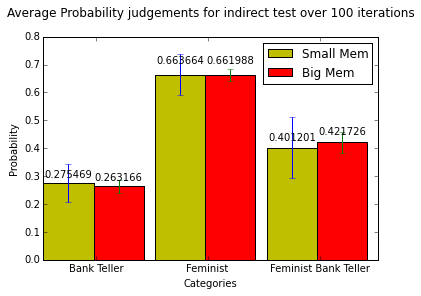

In [32]:
## Bar graph to display the rankings (mean and std) over 100 simulated participants
# with both small exemplar size (B:10, F:10, BF: 3) and big exemplar size (B:100 F:100 BF:30)
# - 26 May, by Huiji

fig, ax = plt.subplots()
p1 = ax.bar(np.arange(0,3,1), indirMean, 0.45, color = 'y', yerr = indirStd)
p2 = ax.bar(np.arange(0,3,1)+0.45, indirMean_b, 0.45, color = 'r', yerr = indirStd_b)
plt.title("Average Probability judgements for indirect test over 100 iterations\n")
plt.xlabel("Categories")
plt.ylabel("Probability")
plt.xticks(np.arange(0,3,1)+0.95/2, ["Bank Teller", "Feminist","Feminist Bank Teller"])
plt.legend((p1[0],p2[0]), ["Small Mem", "Big Mem"])

autolabel(p1)
autolabel(p2)

plt.show()

### Linda Indirect Test: Manipulate category size relationship

#### Keep B, F, and common people the same, vary BF

In [33]:
# Run direct tests with multiple iterations to mimic multiple participants in the human experiments
# with varying BF size for participants (B:40, F:40, CP: 120, BF: x, x from 2 to 30, incrementing by 2)

# Store mean and std for 8 different conditions
indir_varyBF = []

for x in np.arange(2,32,2):
    indir_varyBF_matrix = indirectTest(linda,feat_weights, iterations, features, distribution, [40,40,x,120])
    indir_varyBF_dirStd, indir_varyBF_dirMean = getStdMean(indir_varyBF_matrix)
    X = [indir_varyBF_dirStd, indir_varyBF_dirMean]
    indir_varyBF.append(X)

indir_varyBF = np.array(indir_varyBF)

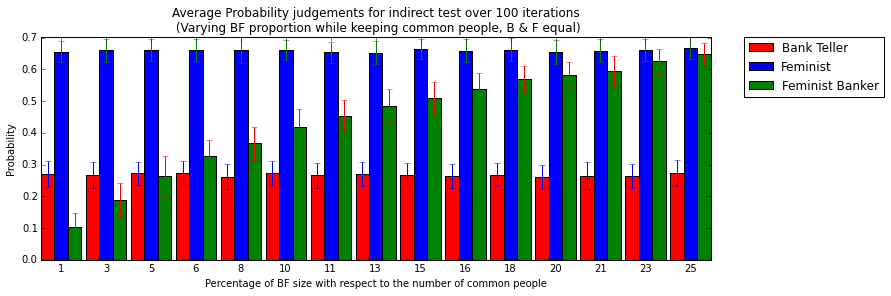

In [54]:
plot_multiple(indir_varyBF,"Average Probability judgements for indirect test over 100 iterations\n (Varying BF proportion while keeping common people, B & F equal)",
             "Percentage of BF size with respect to the number of common people", np.arange(2,32,2)*100//120)

#### Keep F, BF, and common people the same, vary B

In [35]:
# Run direct tests with multiple iterations to mimic multiple participants in the human experiments
# with varying B size for participants (B:x, F:40, CP: 120, BF: 12, x from 40 to 100, incrementing by 4)

# Store mean and std for 8 different conditions
indir_varyB = []

for x in np.arange(40,104,4):
    indir_varyB_matrix = indirectTest(linda,feat_weights, iterations, features, distribution, [x,40,12,120])
    indir_varyB_dirStd, indir_varyB_dirMean = getStdMean(indir_varyB_matrix)
    X = [indir_varyB_dirStd, indir_varyB_dirMean]
    indir_varyB.append(X)

indir_varyB = np.array(indir_varyB)

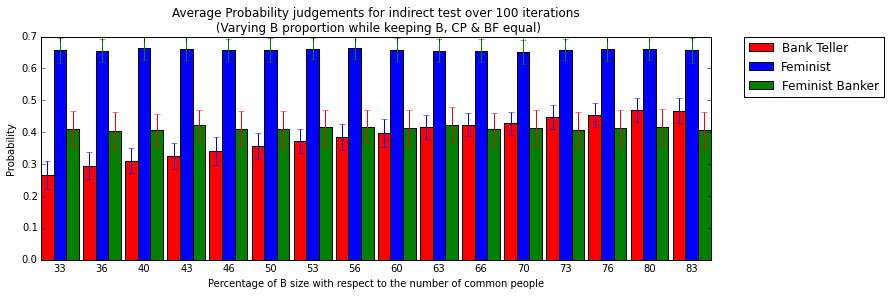

In [36]:
plot_multiple(indir_varyB,"Average Probability judgements for indirect test over 100 iterations\n (Varying B proportion while keeping B, CP & BF equal)",
             "Percentage of B size with respect to the number of common people", np.arange(40,104,4)*100//120)

#### Keep B, BF, and common people the same, vary F

In [37]:
# Run direct tests with multiple iterations to mimic multiple participants in the human experiments
# with varying F size for participants (B:40, F:x, CP: 120, BF: 12, x from 24 to 60, incrementing by 4)

# Store mean and std for 8 different conditions
indir_varyF = []

for x in np.arange(24,64,4):
    indir_varyF_matrix = indirectTest(linda,feat_weights, iterations, features, distribution, [40,x,12,120])
    indir_varyF_dirStd, indir_varyF_dirMean = getStdMean(indir_varyF_matrix)
    X = [indir_varyF_dirStd, indir_varyF_dirMean]
    indir_varyF.append(X)

indir_varyF = np.array(indir_varyF)

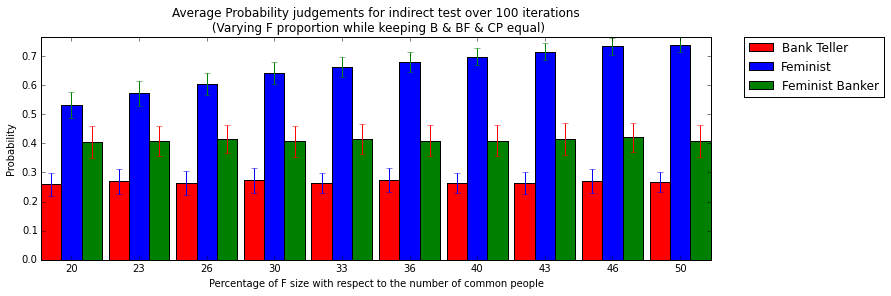

In [38]:
plot_multiple(indir_varyF,"Average Probability judgements for indirect test over 100 iterations\n (Varying F proportion while keeping B & BF & CP equal)",
             "Percentage of F size with respect to the number of common people", np.arange(24,64,4)*100//120)

#### Keep B, F, and BF the same, vary common people

In [39]:
# Run direct tests with multiple iterations to mimic multiple participants in the human experiments
# with varying number of common people for participants (B:40, F:40, CP: x, BF: 12, x from 80 to 200, incrementing by 10)

# Store mean and std for 8 different conditions
indir_varyCP = []

for x in np.arange(80,200,10):
    indir_varyCP_matrix = indirectTest(linda,feat_weights, iterations, features, distribution, [40,40,12,x])
    indir_varyCP_dirStd, indir_varyCP_dirMean = getStdMean(indir_varyCP_matrix)
    X = [indir_varyCP_dirStd, indir_varyCP_dirMean]
    indir_varyCP.append(X)

indir_varyCP = np.array(indir_varyCP)

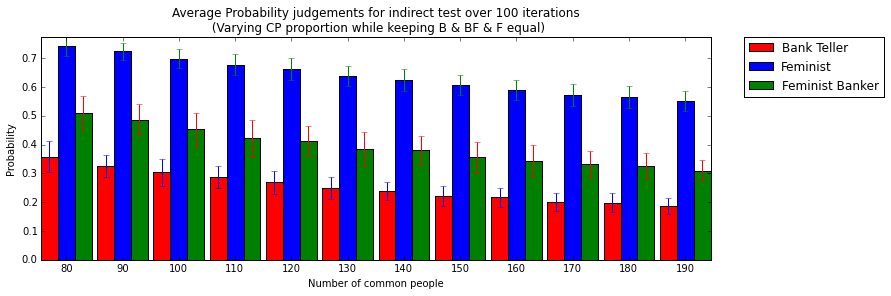

In [40]:
plot_multiple(indir_varyCP,"Average Probability judgements for indirect test over 100 iterations\n (Varying CP proportion while keeping B & BF & F equal)",
             "Number of common people", np.arange(80,200,10))

### Manipulating feature weight distribution (direct test)

In [41]:
iterations = 100
linda = np.array([1,1,1,1,1,1,1,1])

# Change weight of feature 0 (Around 30 years old) - a feature that's more typical for bank tellers than feminists
vary_feat0_weight = []
for x in np.arange(0,1,0.1):
    feat_weights_feat0var = [x,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
    vary_feat0_weight_matrix = directTest(linda,feat_weights_feat0var, iterations, features, distribution, [10,10,3])
    vary_feat0_weight_Std, vary_feat0_weight_Mean = getStdMean(vary_feat0_weight_matrix)
    X = [vary_feat0_weight_Std, vary_feat0_weight_Mean]
    vary_feat0_weight.append(X)

vary_feat0_weight = np.array(vary_feat0_weight)
    

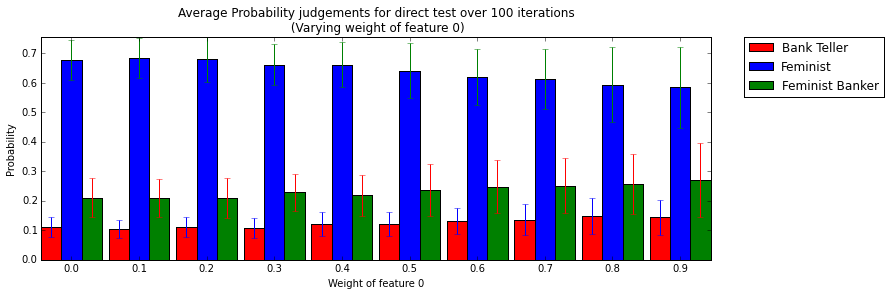

In [42]:
# Graph changes in weight of feature 0 (Around 30 years old)
plot_multiple(vary_feat0_weight,"Average Probability judgements for direct test over 100 iterations\n (Varying weight of feature 0)",
             "Weight of feature 0", np.arange(0,1,0.1))

In [43]:
# Change weight of feature 6 (Participated in demonstrations) - a feature that's more typical for feminists than bank tellers
vary_feat6_weight = []
for x in np.arange(0,1,0.1):
    feat_weights_feat6var = [0.5,0.5,0.5,0.5,0.5,0.5,x,0.5]
    vary_feat6_weight_matrix = directTest(linda,feat_weights_feat6var, iterations, features, distribution, [10,10,3])
    vary_feat6_weight_Std, vary_feat6_weight_Mean = getStdMean(vary_feat6_weight_matrix)
    X = [vary_feat6_weight_Std, vary_feat6_weight_Mean]
    vary_feat6_weight.append(X)

vary_feat6_weight = np.array(vary_feat6_weight)

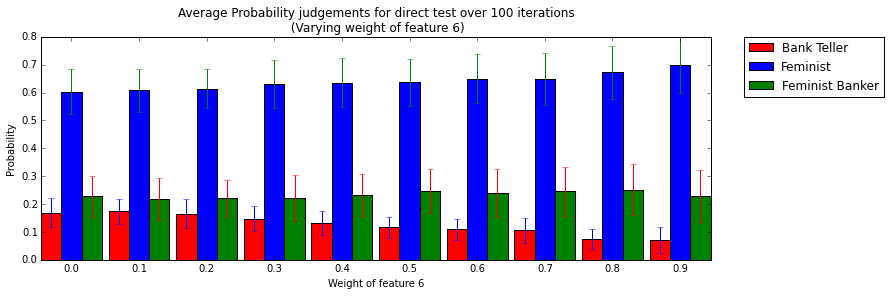

In [44]:
# Graph changes in weight of feature 6 (Participated in demonstrations)
plot_multiple(vary_feat6_weight,"Average Probability judgements for direct test over 100 iterations\n (Varying weight of feature 6)",
             "Weight of feature 6", np.arange(0,1,0.1))

In [45]:
# Change weight of feature 7 (Female) - a feature that's similarly typical for feminists than bank tellers
vary_feat7_weight = []
for x in np.arange(0,1,0.1):
    feat_weights_feat7var = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,x]
    vary_feat7_weight_matrix = directTest(linda,feat_weights_feat7var, iterations, features, distribution, [10,10,3])
    vary_feat7_weight_Std, vary_feat7_weight_Mean = getStdMean(vary_feat7_weight_matrix)
    X = [vary_feat7_weight_Std, vary_feat7_weight_Mean]
    vary_feat7_weight.append(X)

vary_feat7_weight = np.array(vary_feat7_weight)

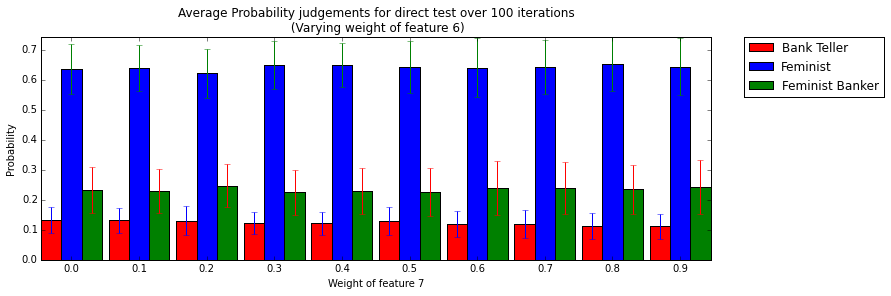

In [46]:
# Graph changes in weight of feature 7 (Participated in demonstrations)
plot_multiple(vary_feat7_weight,"Average Probability judgements for direct test over 100 iterations\n (Varying weight of feature 6)",
             "Weight of feature 7", np.arange(0,1,0.1))

## Placing a distribution over parameters


In [47]:
def directTest_distr_feats(test_stimulus, feat_weights, iterations, features, distribution, num_e_stored):
    dis_feat_Test_matrix = []
    for i in range(iterations):
        # get new table of feature distributions by placing the normal distribution on each one
        distribution_new = []
        for j in range(len(distribution)):
            distribution_new.append([])
            for k in range(len(distribution[j])):
                d = np.random.normal(distribution[j][k], 0.5)
                if d > 1:
                    d = 1
                elif d < 0:
                    d = 0
                distribution_new[j].append(d)
        distribution_new = np.array(distribution_new)
            
        
        # generate new set of exemplars for each participant
        dis_feat_B_exemplars = generate_exemplars(features, distribution_new, 0, num_e_stored[0])
        dis_feat_F_exemplars = generate_exemplars(features, distribution_new, 1, num_e_stored[1])
        dis_feat_BF_exemplars = generate_exemplars(features, distribution_new, 3, num_e_stored[2])
        # concatenate to get the set of all exemplars a participant has
        dis_feat_All_exemplars= np.concatenate((dis_feat_B_exemplars, dis_feat_F_exemplars, dis_feat_BF_exemplars))
    

        dis_feat_cate_list = []
        dis_feat_cate_list.append(prob_retrieve_category(dis_feat_B_exemplars, dis_feat_All_exemplars, test_stimulus, feat_weights))
        dis_feat_cate_list.append(prob_retrieve_category(dis_feat_F_exemplars, dis_feat_All_exemplars, test_stimulus, feat_weights))
        dis_feat_cate_list.append(prob_retrieve_category(dis_feat_BF_exemplars, dis_feat_All_exemplars, test_stimulus, feat_weights))
        dis_feat_Test_matrix.append(dis_feat_cate_list)

    dis_feat_Test_matrix = np.array(dis_feat_Test_matrix)
    return dis_feat_Test_matrix


In [48]:
iterations = 100
linda = np.array([1,1,1,1,1,1,1,1])
feat_weights = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
dis_feat_dirTest_matrix = directTest_distr_feats(linda,feat_weights, iterations, features, distribution, [10,10,3])
dis_feat_dirStd, dis_feat_dirMean = getStdMean(dis_feat_dirTest_matrix)
print (dis_feat_dirStd, dis_feat_dirMean)

[0.12472668856361509, 0.16735404622147568, 0.1247010225835556] [0.19442739075677953, 0.58462820905467749, 0.22094440018854292]


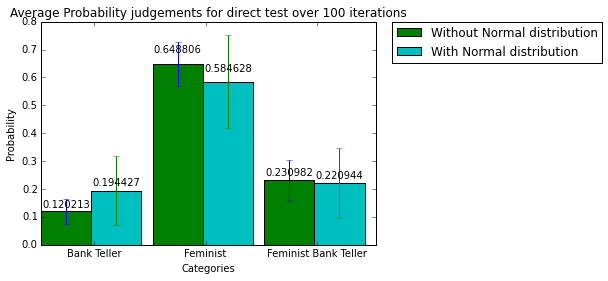

In [49]:
# Bar graph to display the rankings (mean and std) over 100 simulated participants
# Without Normal distribution With Normal distribution


fig, ax = plt.subplots()
       
p1 = ax.bar(np.arange(0,3,1), dirMean, 0.45, color = 'g', yerr = dirStd)
p2 = ax.bar(np.arange(0,3,1)+0.45, dis_feat_dirMean, 0.45, color = 'c', yerr = dis_feat_dirStd)
plt.title("Average Probability judgements for direct test over 100 iterations")
plt.xlabel("Categories")
plt.ylabel("Probability")
plt.xticks(np.arange(0,3,1)+0.95/2, ["Bank Teller", "Feminist","Feminist Bank Teller"])
plt.legend((p1[0],p2[0]), ["Without Normal distribution", "With Normal distribution"]
           ,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

autolabel(p1)
autolabel(p2)

plt.show()

## Direct Test with someone opposite of Linda

In [50]:
iterations = 100
nbnf = np.array([0,0,0,0,0,0,0,0])
feat_weights = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
nbnf_dirTest_matrix = directTest(nbnf,feat_weights, iterations, features, distribution, [10,10,3])
nbnf_dirStd, nbnf_dirMean = getStdMean(nbnf_dirTest_matrix)
print (nbnf_dirStd, nbnf_dirMean)

[0.060723136853096361, 0.05248498619336215, 0.018917969584573653] [0.82347926294716089, 0.14518816908073126, 0.031332567972107886]


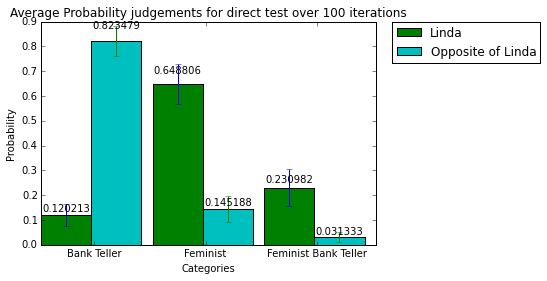

In [51]:
# Bar graph to display the rankings (mean and std) over 100 simulated participants
# With common people and With Linda


fig, ax = plt.subplots()
       
p1 = ax.bar(np.arange(0,3,1), dirMean, 0.45, color = 'g', yerr = dirStd)
p2 = ax.bar(np.arange(0,3,1)+0.45, nbnf_dirMean, 0.45, color = 'c', yerr = nbnf_dirStd)
plt.title("Average Probability judgements for direct test over 100 iterations")
plt.xlabel("Categories")
plt.ylabel("Probability")
plt.xticks(np.arange(0,3,1)+0.95/2, ["Bank Teller", "Feminist","Feminist Bank Teller"])
plt.legend((p1[0],p2[0]), ["Linda", "Opposite of Linda"]
           ,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

autolabel(p1)
autolabel(p2)

plt.show()

## Indirect Test with someone opposite of Linda

In [52]:
nbnf_indirTest_matrix = indirectTest(nbnf,feat_weights, iterations, features, distribution, [10,10,3,30])
nbnf_indirStd, nbnf_indirMean = getStdMean(nbnf_indirTest_matrix)
print (nbnf_indirStd, nbnf_indirMean)

[0.053379212952992777, 0.018817565370363255, 0.0074866751998574005] [0.20595014009329823, 0.047083982116978389, 0.011979386739389841]


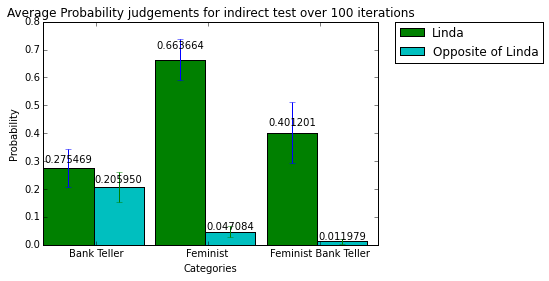

In [53]:
# Bar graph to display the rankings (mean and std) over 100 simulated participants
# With common people and With Linda


fig, ax = plt.subplots()
       
p1 = ax.bar(np.arange(0,3,1), indirMean, 0.45, color = 'g', yerr = indirStd)
p2 = ax.bar(np.arange(0,3,1)+0.45, nbnf_indirMean, 0.45, color = 'c', yerr = nbnf_indirStd)
plt.title("Average Probability judgements for indirect test over 100 iterations")
plt.xlabel("Categories")
plt.ylabel("Probability")
plt.xticks(np.arange(0,3,1)+0.95/2, ["Bank Teller", "Feminist","Feminist Bank Teller"])
plt.legend((p1[0],p2[0]), ["Linda", "Opposite of Linda"]
           ,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

autolabel(p1)
autolabel(p2)

plt.show()